In [ ]:
import cv2
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
from google.colab import drive
import cv2
import numpy as np
import glob
import random
from matplotlib import pyplot as plt
import math

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load Yolo
net = cv2.dnn.readNet("/content/drive/My Drive/train_yolo_to_detect_custom_object/yolo_custom_detection/yolov3_training_final.weights", "/content/drive/My Drive/train_yolo_to_detect_custom_object/yolo_custom_detection/yolov3_testing.cfg")
# Name custom object
classes = ["gun"]

In [ ]:
images_path = glob.glob(r"/content/drive/My Drive/yolov3/images_sample/*.jpg")

In [ ]:
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
colors = np.random.uniform(0, 255, size=(len(classes), 3))

# Insert here the path of your images
random.shuffle(images_path)

In [ ]:
def dist(x1,y1,x2,y2):
  return math.sqrt((x1-x2)**2 + (y1-y2)**2)

In [ ]:
def closest_face(gun_cx,gun_cy,centres):
  min_dist = 100000000
  index_of_face = -1
  i = -1
  for centre in centres:
    i+=1
    cur_dist = dist(gun_cx,gun_cy,centre[0],centre[1])
    if cur_dist < min_dist:
      index_of_face = i
      min_dist = cur_dist
    
  
  return index_of_face


In [ ]:
def gun_detect(path):
  img = cv2.imread(path)
  img = cv2.resize(img, None, fx=0.4, fy=0.4)
  height, width, channels = img.shape

  # Detecting objects
  blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

  net.setInput(blob)
  outs = net.forward(output_layers)

  # Showing informations on the screen
  class_ids = []
  confidences = []
  boxes = []
  center_x = -1
  center_y = -1
  for out in outs:
    for detection in out:
      scores = detection[5:]
      class_id = np.argmax(scores)
      confidence = scores[class_id]
      if confidence > 0.3:
        # Object detected
        print(class_id)
        center_x = int(detection[0] * width)
        center_y = int(detection[1] * height)
        w = int(detection[2] * width)
        h = int(detection[3] * height)

        # Rectangle coordinates
        x = int(center_x - w / 2)
        y = int(center_y - h / 2)

        boxes.append([x, y, w, h])
        confidences.append(float(confidence))
        class_ids.append(class_id)

  indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
  print(indexes)
  font = cv2.FONT_HERSHEY_PLAIN
  for i in range(len(boxes)):
    if i in indexes:
      x, y, w, h = boxes[i]
      label = str(classes[class_ids[i]])
      color = colors[class_ids[i]]
      cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
      cv2.putText(img, label, (x, y + 30), font, 3, color, 2)


  plt.imshow(img)
  plt.show()
  key = cv2.waitKey(0)

  return center_x,center_y


In [ ]:
!git clone https://github.com/nhatthai/opencv-face-recognition.git
protext = "/content/opencv-face-recognition/src/face_detection_model/deploy.prototxt"
weights = "/content/opencv-face-recognition/src/face_detection_model/res10_300x300_ssd_iter_140000.caffemodel"

Cloning into 'opencv-face-recognition'...
remote: Enumerating objects: 129, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 129 (delta 20), reused 114 (delta 5), pack-reused 0
Receiving objects: 100% (129/129), 74.41 MiB | 14.51 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [ ]:
def face_detect(path):
  model  = cv2.dnn.readNetFromCaffe(protext,weights)

  image = cv2.imread(path)
  (h, w) = image.shape[:2]
  blob = cv2.dnn.blobFromImage(cv2.resize(image,(300, 300)), 1.0,(300, 300), (104.0, 177.0, 123.0))
  plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
  #print(image.shape)
  blob = cv2.dnn.blobFromImage(image,1.0,(300, 300), (104.0, 177.0, 123.0),swapRB = True)
  model.setInput(blob)
  detections = model.forward()

  for i in range(0, detections.shape[2]):
    confidence = detections[0, 0, i, 2]
    if confidence > 0.6:
      box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
      (startX, startY, endX, endY) = box.astype("int")
      text = "{:.2f}%".format(confidence * 100)
      y = startY - 10 if startY - 10 > 10 else startY + 10
      cv2.rectangle(image, (startX, startY), (endX, endY),(0, 0, 255), 2)
      cv2.putText(image, text, (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
  plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
  plt.show()
  key = cv2.waitKey(0)

  faces = []
  for i in range(0, detections.shape[2]):
	  confidence = detections[0, 0, i, 2]
	  if confidence > 0.6:
		  box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		  faces.append(box.astype("int"))
  
  centres = []
  for vertices in faces:
    centre_x = (vertices[0]+vertices[2])/2
    centre_y = (vertices[1]+vertices[3])/2
    centres.append((centre_x,centre_y))

  return centres,faces

In [ ]:
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"
gan_model = hub.load(SAVED_MODEL_PATH)

def read_image(path):
  img = cv2.imread(path)
  #img = cv2.resize(img,(64,64),interpolation = cv2.INTER_CUBIC)
  img  = tf.convert_to_tensor(np.asarray(img)/255)
  img = tf.cast(img,tf.float32)
  img = tf.expand_dims(img,axis = 0)
  return img


In [ ]:
def preprocess_image(image_path = None,turn = 0,image = None):
  """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
  """
  if turn == 0:
    hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  else:
    hr_image = image  
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

In [ ]:
from PIL import Image
def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

#4*X prev resolution

i - 0
/content/drive/My Drive/yolov3/images_sample/armas (82).jpg
0
[[0]]


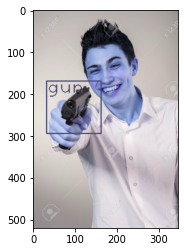

97 232


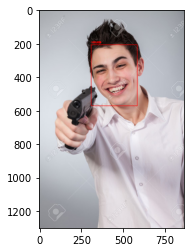

1
0


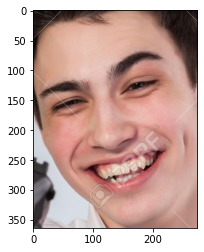

(1456, 1088, 3)
i - 1
/content/drive/My Drive/yolov3/images_sample/armas (81).jpg
0
[[0]]


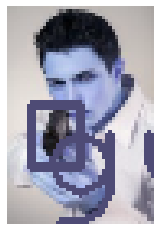

15 40


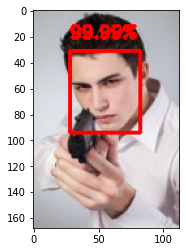

1
0


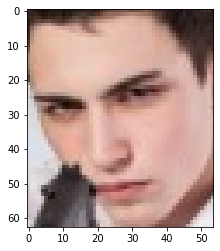

(240, 208, 3)
i - 2
/content/drive/My Drive/yolov3/images_sample/armas (83).jpg
0
[[0]]


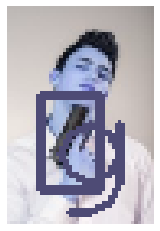

19 42


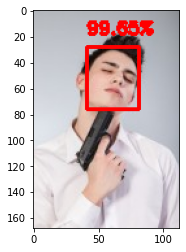

1
0


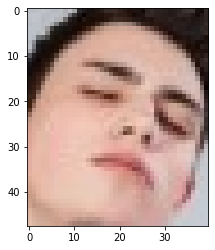

(192, 160, 3)
i - 3
/content/drive/My Drive/yolov3/images_sample/armas (84).jpg
0
0
0
0
0
[[4]
 [2]
 [0]]


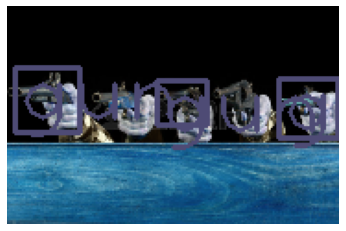

163 55


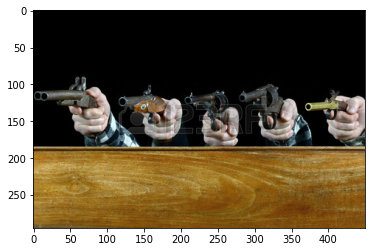

0
-1
i - 3
/content/drive/My Drive/yolov3/images_sample/armas (79).jpg
0
[[0]]


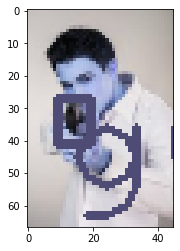

14 34


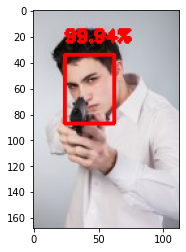

1
0


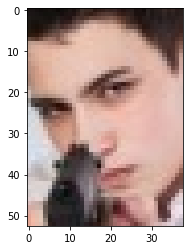

(208, 144, 3)
i - 4
/content/drive/My Drive/yolov3/images_sample/armas (80).jpg
()


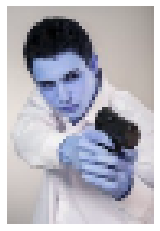

-1 -1


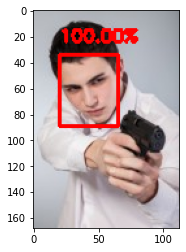

1
0


In [ ]:
i = 0
for img_path in images_path:
  print("i - " + str(i))
  print(img_path)
  ##plt.imshow(cv2.cvtColor(cv2.imread(img_path),cv2.COLOR_BGR2RGB))
  gun_cx,gun_cy = gun_detect(img_path)
  print(gun_cx,gun_cy)
  centres,faces = face_detect(img_path)
  print(len(centres))
  index = closest_face(gun_cx,gun_cy,centres)
  print(index)
  if index != -1 and gun_cx != -1 and gun_cy != -1:
    #gan_model = hub.load(SAVED_MODEL_PATH)

    image = cv2.imread(img_path)[faces[index][1]:faces[index][3],faces[index][0]:faces[index][2]]
    plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    plt.show()
    key = cv2.waitKey(0)

    img = preprocess_image(image = image,turn = 1)
    fake_image = gan_model(img)
    fake_image = tf.squeeze(fake_image)

    plot_image(fake_image)
    print(fake_image.shape)

    i+=1

    
cv2.destroyAllWindows()